# Land Cover Classification
The original land use mentoined in the Landuse_Ma columns of the massavi is out dated and donot match with the ground realities. The land use and total number of parcels in the given dataset are 

  | Land Use      | No. of Parcels | Area (Kanal, Approx.) |
  |---------------|----------------|------------------------|
  | Agriculture   | 5,759          | 32,729                 |
  | Stream        | 302            | 822                    |
  | Other         | 229            | 1,047                  |
  | Road/Street   | 172            | 1,668                  |
  | Graveyard     | 29             | 202                    |
  | Built-Up      | 24             | 602                    |


Some of the anomalies in this dataset are as follow
- The type mentioned in Land use column as agricultue has been converted into builtup, not suitable for crop classification dataset.
- The type mentioned in Land use column as agricultue has now both builtup and agriculture, should be cleaned to make it suiutable for crop classification.
- Some of the on ground agriculture parcels has been recorded as other in Land use column maynot participate in crop classificaiton dataset as per this dataset.
## Purpose
The purpose of this exercise is to get clean agriculture parcels dataset for crop classificaiton using artifical intelligence algorithms like random forest, SVM etc. 

## Data Cleansing Methodology:
Since the agriculture column in the Land use column does not give us a clear idea of the current land type therefore, we have to use other means to computer the current land use type. Therefore, as first step we will filter the 5,759 agriculter parcels and compute NDVI and NDBI.
1. Get imagery from the ee for the time peroid. In this case i got 135 images for the year 2024. 
2. Pure agriculture: if NDVI is >= 3 and <= 7  the current_land_type is agriculture
3. Pure builtup: if the NDBI value is >0 and NDVI value is <=2 the current_land_type is builtup
4. Mix: compute the percentage parcel coverage of NDVI and NDBI and use a threshold to classify either builtup or agriculture
The resultant dataset will be clean revised agriculture parcels and can be used for crop classification.





In [43]:
#Step 1: Load the original dataset having Landuse_Ma columon. This dataset also have crop information. 

import geopandas as gpd
import pandas as pd
import numpy as np
import leafmap
import geemap
import ee

In [3]:
cropfile = 'pabbi_crop.geojson'
gdf = gpd.read_file(cropfile)
gdf['Landuse_Ma'].groupby(gdf['Landuse_Ma']).count().sort_values(ascending=False)

Landuse_Ma
Agriculture     5759
Stream           302
Other            229
Road/Streets     172
Graveyard         29
Built up          24
Name: Landuse_Ma, dtype: int64

In [4]:

selected_parcels = gdf[gdf['Landuse_Ma'] == 'Agriculture']
print(f'Total Agriculture Parcels are :{len(selected_parcels)}') 
# These are the parcels with Landuse_Ma as Agriculture and will be used for further analysis.

Total Agriculture Parcels are :5759


## Data Cleansing
1. Calculating NDVI and NDBI of the selected agriculture parcels : 5759.

In [5]:
# Lets Convert the gdf of the original file to ee features utilizing earth engine power
ee.Initialize()
ee.Authenticate()
boundary = geemap.gdf_to_ee(gdf) # this is for cliping the images
selectedparcels_fc = geemap.gdf_to_ee(selected_parcels) # this is for getting the agriculture parcels features Collection 


In [6]:
# Define a function to get imagery an apply filter
def get_collection (start_date,end_date):
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    filtered_collection = collection.filterDate(start_date, end_date).filterBounds(boundary.geometry()).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    return filtered_collection

In [7]:
# defing ndvi , NDBI , BUI and UI indices

def get_ndvi(filtered_collection):
    # Calculate the annual NDVI from the filtered collection (filtered_collection)
    ndvi_collection = filtered_collection.map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('NDVI'))
    # Calculate the mean NDVI for the year
    mean_ndvi = ndvi_collection.mean()
    return mean_ndvi
    
def get_ndbi(filtered_collection):
    # Calculate Normalized Difference Built-up Index (NDBI) (SWIR−NIR)/(SWIR+NIR) from the filtered collection filtered_collection
    # NDBI = (B11 - B8) / (B11 + B8)
    # Built‑up areas (positive values) vs. vegetation/water (negative)
    ndbi_collection = filtered_collection.map(lambda img: img.normalizedDifference(['B11', 'B8']).rename('NDBI'))
    # Calculate the mean NDBI for the year
    mean_ndbi = ndbi_collection.mean()
    return mean_ndbi

def get_bui(filtered_collection):
    # Calculate the annual Built-Up Index (BUI) for an ee.ImageCollection `filtered_collection`.
    # BUI: (B11 + B4 - B8 - B2) / (B11 + B4 + B8 + B2)
    # Enhances urban density separation from other land‑covers
    bui_collection = filtered_collection.map(lambda img: (img.select('B11').add(img.select('B4')).subtract(img.select('B8'))
           .subtract(img.select('B2'))
           .divide(
               img.select('B11').add(img.select('B4'))
                  .add(img.select('B8'))
                  .add(img.select('B2'))
           )
           .rename('BUI')      
                    ))
    mean_bui = bui_collection.mean()
    return mean_bui
    
def get_ui(filtered_collection):
    # Calculate Urban Index (UI) (NDBI−NDVI)/(NDBI+NDVI) for the collection
    # Separates built‑up from vegetation more robustly
    mean_ndvi = get_ndvi(filtered_collection)
    mean_ndbi = get_ndbi(filtered_collection)
    mean_ui = mean_ndbi.subtract(mean_ndvi).divide(mean_ndbi.add(mean_ndvi)).rename('UI')
    return mean_ui



In [8]:
def get_composite(ndvi_img, ndbi_img, bui_img, ui_img):
    """
    Stack the four annual‐mean index images into one composite,
    then clip it to the boundary.
    """
    # 1. Concatenate the four single‐band images
    composite_img = ee.Image.cat([ndvi_img, ndbi_img, bui_img, ui_img])
    
    # 2. Rename the bands in the correct order
    composite_img = composite_img.rename(['NDVI','NDBI','BUI','UI'])
    
    # 3. Clip to your boundary
    composite_img = composite_img.clip(boundary.geometry())
    
    return composite_img


In [9]:
filtered_collection = get_collection('2024-01-01', '2024-12-31')
ndvi_img = get_ndvi(filtered_collection)
ndbi_img = get_ndbi(filtered_collection)
bui_img = get_bui(filtered_collection)
ui_img = get_ui(filtered_collection)

composite_img = get_composite(ndvi_img, ndbi_img, bui_img, ui_img)

In [10]:
filtered_collection.size().getInfo() # this will give the number of images in the collection

135

## Create a binary mask for each pixel in the composite.
1. if the NDVI value of a pixel is greater than 0.25 it is agricultue pixel
2. if the NDBI value of a pixel is greater than 0.0 than it is a builtup pixel

In [11]:
builtmask = composite_img.select('BUI').gt(0)
agrimask = composite_img.select('NDVI').gt(0.25)

In [12]:
  # Getting pixel count for calculating percentage of parcel and plx mean for pure agri/built 
def sum_count(composite_img, builtmask, agrimask, parcels_fc):
    
    built = builtmask.rename('built_count').toInt()
    agri  = agrimask.rename('agri_count').toInt()

    mask_img = ee.Image.cat([built, agri])

    pixel_sum = mask_img.reduceRegions(
        collection=parcels_fc,
        reducer=ee.Reducer.sum(),
        scale=10,
        crs=composite_img.projection()
    )
    return pixel_sum

def mean_indices(composite_img, parcels_fc):
    ndvi = composite_img.select('NDVI')
    ndbi = composite_img.select('NDBI')
    ui = composite_img.select('UI')
    bui = composite_img.select('BUI')

    index_img = ee.Image.cat([ndvi,ndbi,bui,ui])
    mean_img = index_img.reduceRegions(
        collection=parcels_fc,
        reducer=ee.Reducer.mean(),
        scale=10,
        crs=composite_img.projection()
    )
    return mean_img


In [13]:
pxlsum = sum_count(composite_img, builtmask, agrimask, selectedparcels_fc)
pxlmean = mean_indices(composite_img, selectedparcels_fc)
# Convert the ee.FeatureCollection to a pandas DataFrame
pxlsum_gdf= geemap.ee_to_gdf(pxlsum)
pxlmean_gdf= geemap.ee_to_gdf(pxlmean)  


In [16]:
# since both dataframes have duplicate columns therefore to avoid duplicaiton 
# we will select the columns we need for merging
mean_cols = ['geometry','NDVI','NDBI','BUI','UI']
plxmean_small = pxlmean_gdf[mean_cols]

#Now we will merge the two dataframes
stats_gdf = pxlsum_gdf.merge(plxmean_small, on='geometry', how='left')

print(stats_gdf.columns.tolist())

['geometry', 'Area_Acre', 'Crop_Type', 'FFID', 'Landuse_Ma', 'Mouza_Name', 'Parcel_ID', 'agri_count', 'built_count', 'NDVI', 'NDBI', 'BUI', 'UI']


In [17]:
# Now stats_gdf has columns 'built_count' and 'agri_count' per parcel
# Lets compute the percentage of built and agri land
stats_gdf['pct_built'] = stats_gdf['built_count'] / (stats_gdf['built_count'] + stats_gdf['agri_count'])
stats_gdf['pct_agri']  = stats_gdf['agri_count']  / (stats_gdf['built_count'] + stats_gdf['agri_count'])

In [18]:
stats_gdf.columns.tolist()

['geometry',
 'Area_Acre',
 'Crop_Type',
 'FFID',
 'Landuse_Ma',
 'Mouza_Name',
 'Parcel_ID',
 'agri_count',
 'built_count',
 'NDVI',
 'NDBI',
 'BUI',
 'UI',
 'pct_built',
 'pct_agri']

In [53]:
def classify_parcel(row,
                    ndvi_barren_thresh=0.2,
                    ui_built_thresh=0.1,
                    maj_thresh=0.75,
                    min_thresh=0.25):
    ndvi = row['NDVI']
    ui   = row['UI']
    pa   = row['pct_agri']
    pb   = row['pct_built']

    # 1a) Absolutely pure agriculture
    if pa == 1.0:
        return 'Pure-Agriculture'

    # 1b) Absolutely pure built-up
    if pb == 1.0:
        return 'Pure-Builtup'

    # 2a) Strong pure agriculture
    if pa >= maj_thresh:
        return 'Pure-Agriculture'

    # 2b) Strong pure built-up
    if pb >= maj_thresh:
        return 'Pure-Builtup'

    # 3) Barren
    if ndvi < ndvi_barren_thresh and abs(ui) < ui_built_thresh:
        return 'Barren'

    # 4a) Partial agriculture
    if pa >= min_thresh and pa > pb:
        return 'Partial-Agriculture'

    # 4b) Partial built-up
    if pb >= min_thresh and pb > pa:
        return 'Partial-Builtup'

    # 5) Mixed / no clear leader
    return 'Mixed'

# Apply to your GeoDataFrame
stats_gdf['landuse_class'] = stats_gdf.apply(classify_parcel, axis=1)

# Quick tally
print(stats_gdf['landuse_class'].value_counts())


landuse_class
Pure-Agriculture       2945
Partial-Agriculture    1269
Pure-Builtup            810
Partial-Builtup         643
Mixed                    92
Name: count, dtype: int64


In [54]:
pure_agri = stats_gdf[stats_gdf['landuse_class'] == 'Pure-Agriculture']
pure_built = stats_gdf[stats_gdf['landuse_class'] == 'Pure-Builtup']
partial_agri = stats_gdf[stats_gdf['landuse_class'] == 'Partial-Agriculture']
partial_built = stats_gdf[stats_gdf['landuse_class'] == 'Partial-Builtup']
mixed = stats_gdf[stats_gdf['landuse_class'] == 'Mixed']
barren = stats_gdf[stats_gdf['landuse_class'] == 'Barren']

In [ ]:
m = leafmap.Map(center=(37.5, 70), zoom=6)
m.add_basemap('Google Satellite')

# 1. Create a minimal GeoDataFrame with only geometry + landuse_class
popup_gdf = stats_gdf[['geometry', 'landuse_class']].copy()


legend_dict = {
    'Pure Agriculture':   '#00AA00',  # dark green
    'Pure Builtup':       '#0000FF',  # blue
    'Partial Agriculture':'#FFA500',  # orange
    'Partial Builtup':    '#800080',  # purple
    'Mixed':              '#FFFF00',  # yellow
    'Barren':             '#808080',  # gray, if you have that class
}


m.add_gdf(
    popup_gdf,
    layer_name='Landuse Class',
    style={                      # pick any style you like
        'color':   'black',
        'fillColor':'transparent',
        'weight':  1
    },
    zoom_to_layer=False,
    info_mode='on_click'        # show popup when you click
)

# Pure Agriculture
m.add_gdf(
    pure_agri,
    layer_name='Pure Agriculture',
    style={
        'color': 'green',      # border
        'fillColor': 'green',  # interior
        'fillOpacity': 0.4,
        'weight': 1
    },
    zoom_to_layer=True, 
)

# Pure Builtup
m.add_gdf(
    pure_built,
    layer_name='Pure Builtup',
    style={
        'color': 'blue',
        'fillColor': 'blue',
        'fillOpacity': 0.4,
        'weight': 1
    }, info_mode = 'off'
    
)

# Partial Agriculture
m.add_gdf(
    partial_agri,
    layer_name='Partial Agriculture',
    style={
        'color': 'orange',
        'fillColor': 'orange',
        'fillOpacity': 0.4,
        'weight': 1
    },info_mode = 'off'
    
)

# Partial Builtup
m.add_gdf(
    partial_built,
    layer_name='Partial Builtup',
    style={
        'color': 'purple',
        'fillColor': 'purple',
        'fillOpacity': 0.4,
        'weight': 1
    },info_mode = 'off'
    
)

# Mixed
m.add_gdf(
    mixed,
    layer_name='Mixed',
    style={
        'color': 'yellow',
        'fillColor': 'yellow',
        'fillOpacity': 0.4,
        'weight': 1
    },info_mode = 'off'
    
)
m.add_legend(
    legend_title='Landuse Classification',
    legend_dict=legend_dict,
    position='bottomleft'
)

m




Map(center=[37.5, 70], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [20]:
stats_gdf.head()

,geometry,Area_Acre,Crop_Type,FFID,Landuse_Ma,Mouza_Name,Parcel_ID,agri_count,built_count,NDVI,NDBI,BUI,UI,pct_built,pct_agri,landuse_class
0,"POLYGON ((71.74996 34.03193, 71.75027 34.03195...",0.101785,None,1,Agriculture,Khushmaqam,668,1.152941,4.980392,0.224979,-0.011819,0.040415,-1.152070,0.812020,0.187980,Partial-Builtup
1,"POLYGON ((71.74868 34.03205, 71.74869 34.03195...",0.315557,None,3,Agriculture,Khushmaqam,632,7.882353,12.996078,0.268993,-0.000361,0.046918,-0.967483,0.622464,0.377536,Partial-Builtup
2,"POLYGON ((71.75021 34.03218, 71.75022 34.0321,...",0.187644,None,4,Agriculture,Khushmaqam,669,5.988235,9.149020,0.260441,-0.005099,0.042763,-1.030890,0.604404,0.395596,Partial-Builtup
3,"POLYGON ((71.75401 34.03224, 71.75403 34.03219...",0.161568,None,5,Agriculture,Khushmaqam,693,6.192157,1.698039,0.492108,-0.161509,-0.095039,-1.924145,0.215209,0.784791,Pure-Agriculture
4,"POLYGON ((71.74971 34.03192, 71.74996 34.03193...",0.229336,None,6,Agriculture,Khushmaqam,667,2.109804,10.537255,0.191511,-0.012476,0.038271,-1.600421,0.833178,0.166822,Partial-Builtup


In [39]:
stats_gdf.to_file('Pabbi_RevisedLandtype.geojson', driver='GeoJSON')

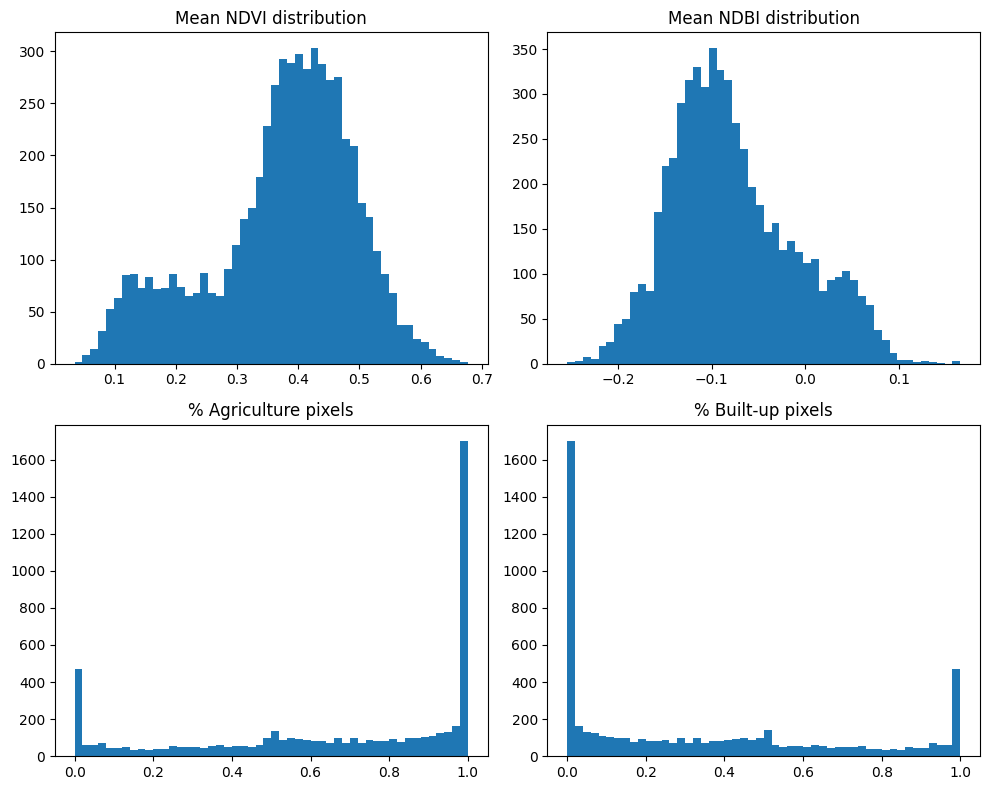

In [132]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2, figsize=(10,8))

axes[0,0].hist(stats_gdf['NDVI'], bins=50)
axes[0,0].set_title('Mean NDVI distribution')

axes[0,1].hist(stats_gdf['NDBI'], bins=50)
axes[0,1].set_title('Mean NDBI distribution')

axes[1,0].hist(stats_gdf['pct_agri'], bins=50)
axes[1,0].set_title('% Agriculture pixels')

axes[1,1].hist(stats_gdf['pct_built'], bins=50)
axes[1,1].set_title('% Built-up pixels')

plt.tight_layout()
plt.show()
